In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import h5py
import itertools 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from  keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential


Using TensorFlow backend.


In [57]:
D=[]
check=[]
label = []
for folder in ["32_7ms_noise/ok","32_7ms_noise/nok"]:
    i = 0
    for file in os.listdir(folder):
        if(".npy" in file):
            spectogram = np.load(folder+"/"+file)
            if spectogram.shape != (96, 32): continue
            D.append((spectogram, folder))
            label.append(folder)
            check.append(spectogram) #może tu normalizować
            i+=1
print(len(D),len(D[0]),"done")

5632 2 done


In [32]:
D=[]
D_ok = []
D_nok = []
check=[]
label = []
for folder in ["32_7ms_noise/ok","32_7ms_noise/nok"]:
    i = 0
    for file in os.listdir(folder):
        if(".npy" in file):
            if("noisy" not in file):
                spectogram = np.load(folder+"/"+file)
                if spectogram.shape != (96, 32): continue
                if(folder == "32_7ms_noise/ok"):
                    D_ok.append((spectogram, folder))
                    label.append(folder)
                    check.append(spectogram) #może tu normalizować
                    i+=1
                else:
                    D_nok.append((spectogram, folder))
                    label.append(folder)
                    check.append(spectogram) #może tu normalizować
                    i+=1
random.shuffle(D_ok)
D = D_ok#[:2000]
{D.append(x) for x in D_nok}
print(len(D_nok),len(D_nok[0]))
print(len(D_ok),len(D_ok[0]))
print(len(D),len(D[0]),"done")
#1102

287 2
2816 2
2816 2 done


In [ ]:
def noise_add(array):
    noise = np.load("32_7ms_noise/noise/noise{}.npy".format(random.randint(0, 49)))
    output = array+noise
    return output

In [ ]:
#with data augmentation on cracks which goes to lerning
D=[]
D_ok = []
D_nok = []
check=[]
label = []
for folder in ["32_7ms_noise/ok","32_7ms_noise/nok"]:
    i = 0
    for file in os.listdir(folder):
        if(".npy" in file):
            if("noisy" not in file):
                spectogram = np.load(folder+"/"+file)
                if spectogram.shape != (96, 32): continue
                if(folder == "32_7ms_noise/ok"):
                    D_ok.append((spectogram, folder))
                    label.append(folder)
                    check.append(spectogram) #może tu normalizować
                    i+=1
                else:
                    D_nok.append((spectogram, folder))
                    label.append(folder)
                    check.append(spectogram) #może tu normalizować
                    i+=1
random.shuffle(D_ok)
random.shuffle(D_nok)
#201 przeznaczone na naukę
train_nok = D_nok[:201]
walid_nok = D_nok[201:]
train_ok = D_ok[:400]
walid_ok = D_ok[400:520]
train_nok_augmented = [[noise_add(x[0]),x[1]] for x in train_ok]


train_a=train_nok
{train_a.append(x) for x in train_ok}
#{train_a.append(x) for x in train_nok_augmented}
walid_a=walid_nok
{walid_a.append(x) for x in walid_ok}

#print(train_a)
#
D = D_ok[:500]
{D.append(x) for x in D_nok}
print(len(D_nok),len(D_nok[0]))
print(len(D_ok),len(D_ok[0]))
print(len(train_a),len(train_a[0]))
print(len(D),len(D[0]),"done")
#1102

In [33]:
def normalization(data,x_max,x_min):
    diff = x_max-x_min
    for rows in range(0,len(data)):
        for cols in range(0,len(data[0])):
            data[rows][cols] = (data[rows][cols]-x_min)/diff 
    return data

In [34]:
dataset_min = np.amin(check)
dataset_max = np.amax(check) #jak teraz znormalizuje to jak potem to zrobić?
print(dataset_min,dataset_max)
dataset_normalized = []
for data in D:
    dataset_normalized.append([normalization(data[0],dataset_max,dataset_min),data[1]])
  
#print(np.amin(dataset_normalized[0:][0]),np.amax(dataset_normalized)[0:][0])
'''train_a_norm = []
for data in train_a:
    train_a_norm.append([normalization(data[0],dataset_max,dataset_min),data[1]])
    
walid_a_norm = []
for data in walid_a:
    walid_a_norm.append([normalization(data[0],dataset_max,dataset_min),data[1]])'''

9.303502839404124e-10 0.0006509951221093927


'train_a_norm = []\nfor data in train_a:\n    train_a_norm.append([normalization(data[0],dataset_max,dataset_min),data[1]])\n    \nwalid_a_norm = []\nfor data in walid_a:\n    walid_a_norm.append([normalization(data[0],dataset_max,dataset_min),data[1]])'

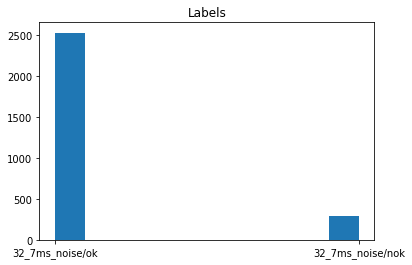

In [35]:
plt.hist(label)  # arguments are passed to np.histogram
plt.title("Labels")
plt.show()

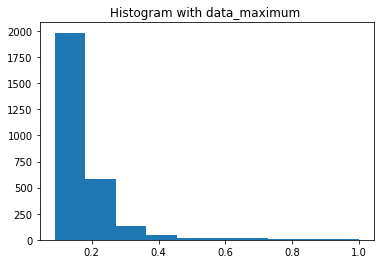

In [36]:
plt.hist([np.amax(data_x[0]) for data_x in dataset_normalized])  # arguments are passed to np.histogram
plt.title("Histogram with data_maximum ")
plt.show()

In [37]:
def Oversampling(train):
    class1=0 #"32_7ms_noise/ok"
    class2=0
    newtrain = []
    for x in train:
        if(x[1]=="32_7ms_noise/ok"):
            class1+=1
            newtrain.append([x[0],x[1]])
        else:
            class2+=1
            newtrain.append([x[0],x[1]])
    print(class1,class2)
    if(class1<class2):
        return train
    while(class1>class2):
        for x in train:
            if(x[1]!="32_7ms_noise/ok"):
                class2+=1
                newtrain.append([x[0],x[1]])
                if(class2==class1):
                    return newtrain

In [38]:
dataset_array = keras.utils.normalize(check,axis=-1,order=2)
dataset = dataset_normalized

print(len(D))
print(len(D[0]))
print(len(D[0][0]))
print(len(D[0][0][0]))
random.shuffle(dataset)

tresh = int((len(dataset))*0.7)
train = dataset[:tresh]
print("before",len(train))
train = Oversampling(train)
print("after",len(train))
test = dataset[tresh:]
##augment
#random.shuffle(train_a_norm)
#random.shuffle(walid_a_norm)
#train = train_a_norm
#test = walid_a_norm

x_train, y_train = zip(*train)
x_test, y_test = zip(*test)

# Reshape for CNN input
fft_size = 96
cols = 32
x_train = np.array([x.reshape( (fft_size, cols, 1) ) for x in x_train])
x_test = np.array([x.reshape( (fft_size, cols, 1) ) for x in x_test])

# One-Hot encoding for classes
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
print(y_test)

2816
2
96
32
before 1971
1764 207
after 3528
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 

In [ ]:
#architekrura 128x32
model = Sequential()
input_shape=(128, 32, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

In [31]:
#architektura 96x32
a,b,c=12,12,12


model = Sequential()
input_shape=(fft_size, cols, 1)

model.add(Conv2D(a, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(b, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(c, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 92, 28, 12)        312       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 46, 14, 12)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 46, 14, 12)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 10, 12)        3612      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 5, 12)         0         
_________________________________________________________________
activation_10 (Activation)   (None, 10, 5, 12)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 1, 12)          3612      
__________

In [39]:
d=4
Tensor_board = keras.callbacks.TensorBoard(log_dir='./model_funkcjonalny/filterNumbers{0}_{1}_{2}_{3}'.format(a,b,c,d), write_images=True)
filepath="./model_funkcjonalny/weights-improvement{0}_{1}_{2}_{3}.hdf5".format(a,b,c,d)
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor="acc", verbose=1, save_best_only=True)
callbacks_list = [checkpoint,Tensor_board]

In [ ]:
optimazerAdam = keras.optimizers.Adam(lr=0.0001, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])#accuracy

history = model.fit(x_train, y_train,
          epochs=60,
          batch_size=128,
          validation_data =(x_test, y_test),
          callbacks = callbacks_list)

score = model.evaluate(x_test, y_test, batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
## tensorboard --logdir C:\Users\Jakub\praca_inzynierska\Scissors_falling\logs --port=8080

Train on 3528 samples, validate on 845 samples
Epoch 1/60
3528/3528 [==============================] - 12s 3ms/step - loss: 0.6927 - acc: 0.5133 - val_loss: 0.7037 - val_acc: 0.0947

Epoch 00001: acc improved from -inf to 0.51332, saving model to ./model_funkcjonalny/weights-improvement12_12_12_4.hdf5
Epoch 2/60
3528/3528 [==============================] - 12s 3ms/step - loss: 0.6848 - acc: 0.5573 - val_loss: 0.6742 - val_acc: 0.8189

Epoch 00002: acc improved from 0.51332 to 0.55726, saving model to ./model_funkcjonalny/weights-improvement12_12_12_4.hdf5
Epoch 3/60
3528/3528 [==============================] - 13s 4ms/step - loss: 0.6312 - acc: 0.7338 - val_loss: 0.6111 - val_acc: 0.8828

Epoch 00003: acc improved from 0.55726 to 0.73384, saving model to ./model_funkcjonalny/weights-improvement12_12_12_4.hdf5
Epoch 4/60
3528/3528 [==============================] - 13s 4ms/step - loss: 0.5158 - acc: 0.8135 - val_loss: 0.4788 - val_acc: 0.9598

Epoch 00004: acc improved from 0.73384 to 0

In [29]:
model.load_weights("./logs/filterNumbers/weights-improvement{0}_{1}_{2}_{3}.hdf5".format(a,b,c,d))#dodaj d

In [ ]:
print(history.history)

In [ ]:
model.save_weights("model_128_7ms.h5")
print("Saved model to disk")

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Prawdziwa etykieta')
    plt.xlabel('Przewidziana etykieta')
    plt.tight_layout()

Confusion matrix, without normalization


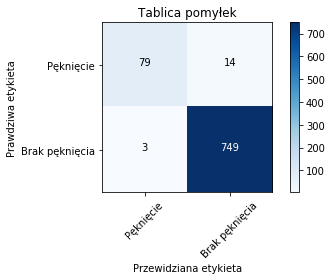

In [3]:
plt.figure()
plot_confusion_matrix(np.array([[79,14],[3,749]]), classes=["Pęknięcie",'Brak pęknięcia'],
                      title='Tablica pomyłek')

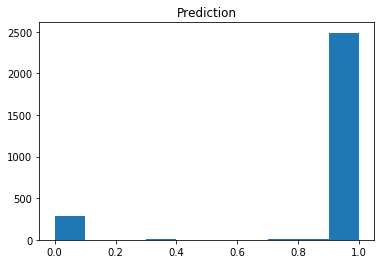

[[ 283    4]
 [  19 2510]]
Confusion matrix, without normalization
Recall/Czułość: 0.986 Precision/Precyzja: 0.937 F-Score: 0.961


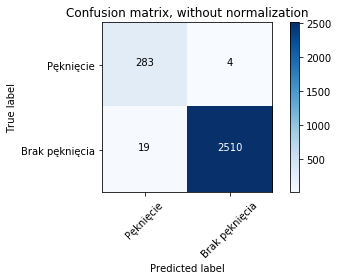

In [49]:
#whole dataset
prediction = []
prediction_label =[]
prediction_predicted = []
dat = dataset
train_xx, train_yy = zip(*dat)
dataset_normalized = []
'''for data in train_xx:
    dataset_normalized.append(normalization(data,dataset_max,dataset_min))
''' 
train_xx = np.array([x.reshape( (fft_size, cols, 1) ) for x in train_xx])
#print(train_xx)  
for i in range(0,len(D)):
    prediction.append(model.predict(train_xx[i].reshape(1,fft_size,cols,1))[0][0])
    prediction_label.append(train_yy[i])
    prediction_predicted.append(round(prediction[i]))
    
prediction_label = encoder.transform(prediction_label)    
#print(prediction,prediction_label)
#for check_item in dataset_normalized:
#   prediction.append(model.predict(check_item[0].reshape(1,128,128,1))[0][0])
#   prediction_label.append(check_item[1])
#    if(prediction[-1]>0.5):
#       prediction_predicted.append("128_7ms/ok")
#    else:
#        prediction_predicted.append("128_7ms/nok")
        
plt.hist(prediction)  # arguments are passed to np.histogram
plt.title("Prediction")
plt.show()
matrix = confusion_matrix(y_pred=prediction_predicted,y_true=prediction_label)
print(matrix)
plt.figure()
plot_confusion_matrix(matrix, classes=["Pęknięcie",'Brak pęknięcia'],
                      title='Confusion matrix, without normalization')
precision = (matrix[0][0])/(matrix[0][0]+matrix[1][0])
recall = (matrix[0][0])/(matrix[0][0]+matrix[0][1])
score = 2/((1/recall) + (1/precision))
print("Recall/Czułość: {0:0.3f}".format(recall),"Precision/Precyzja: {0:0.3f}".format(precision),"F-Score: {0:0.3f}".format(score))

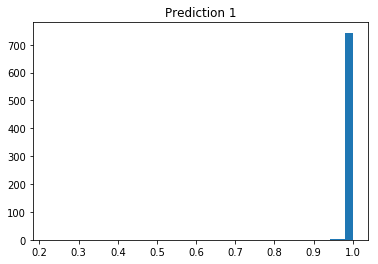

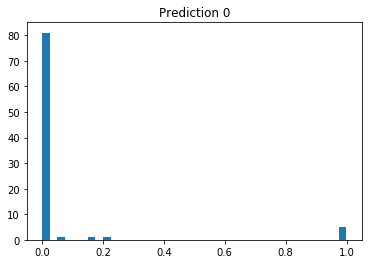

[[ 84   5]
 [  2 754]]
Confusion matrix, without normalization
Recall/Czułość: 0.944 Precision/Precyzja: 0.977 F-Score: 0.960


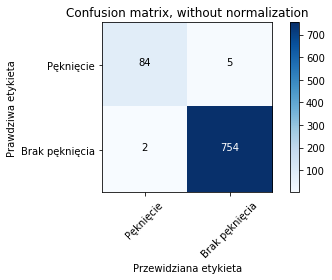

In [30]:
prediction = []
prediction_label =[]
prediction_predicted = []
for i in range(0,len(y_test)):
    prediction.append(model.predict(x_test[i].reshape(1,fft_size,32,1))[0][0])
    prediction_label.append(y_test[i])
    prediction_predicted.append(round(prediction[i]))
    
  
#print(prediction,prediction_label)
#for check_item in dataset_normalized:
#   prediction.append(model.predict(check_item[0].reshape(1,128,128,1))[0][0])
#   prediction_label.append(check_item[1])
#    if(prediction[-1]>0.5):
#       prediction_predicted.append("128_7ms/ok")
#    else:
#        prediction_predicted.append("128_7ms/nok")
        
plt.hist([prediction[x] for x in range(len(y_test)) if(prediction_label[x]==1) ],bins=40)  # arguments are passed to np.histogram
plt.title("Prediction 1")
plt.show()
plt.hist([prediction[x] for x in range(len(y_test)) if(prediction_label[x]==0) ],bins=40)  # arguments are passed to np.histogram
plt.title("Prediction 0")
plt.show()
matrix = confusion_matrix(y_pred=prediction_predicted,y_true=prediction_label)
print(matrix)
plt.figure()
plot_confusion_matrix(matrix, classes=["Pęknięcie",'Brak pęknięcia'],
                      title='Confusion matrix, without normalization')
precision = (matrix[0][0])/(matrix[0][0]+matrix[1][0])
recall = (matrix[0][0])/(matrix[0][0]+matrix[0][1])
score = 2/((1/recall) + (1/precision))
print("Recall/Czułość: {0:0.3f}".format(recall),"Precision/Precyzja: {0:0.3f}".format(precision),"F-Score: {0:0.3f}".format(score))

In [ ]:
# this function will plot all the feature maps within a fig of size (20,20)
def plot_feature_maps(feature_maps):
    height, width, depth = feature_maps.shape
    nb_plot = int(np.rint(np.sqrt(depth)))
    fig = plt.figure(figsize=(20, 20))
    for i in range(depth):
        plt.subplot(nb_plot, nb_plot, i+1)
        plt.imshow(feature_maps[:,:,i], cmap='gray')
        plt.title('feature map {}'.format(i+1))
    plt.show()

In [53]:
a = model.get_weights()
print(a[0])

[[[[-0.16226606  0.1097696   0.17509937 -0.06637171  0.03461435
     0.17408952 -0.13903853 -0.06435193  0.01108869  0.01784367]]

  [[-0.19274618 -0.17258947 -0.090211   -0.11480455 -0.00163711
     0.0137758  -0.07664757 -0.00380536 -0.04555513 -0.01756856]]

  [[ 0.06285418  0.06411916  0.05712641 -0.03322889 -0.02574914
     0.0783181   0.20405358  0.01774206  0.0197495  -0.212298  ]]

  [[ 0.11534175 -0.03310899 -0.19626923  0.05805558 -0.05519095
     0.22905187 -0.06348664  0.05409367 -0.01241336  0.00238702]]

  [[ 0.08682427 -0.1434245  -0.0284793  -0.09802491 -0.16484094
     0.00549193  0.05913175  0.01126923  0.15981911 -0.01003391]]]


 [[[-0.07350381  0.31072646  0.06876894  0.14232567 -0.08449425
     0.09430775 -0.07846385 -0.168907    0.18811116  0.07201267]]

  [[ 0.03577217  0.14844368  0.17999123  0.0235864   0.22561437
    -0.11515439 -0.03431041 -0.08313715  0.17385882 -0.07403462]]

  [[-0.20981495 -0.09109115  0.08460326  0.07741213 -0.00972293
    -0.1268023  -

In [130]:
def plot_conv_weights(model, index):
    W = model.get_layer(index=index).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2])) 
        fig, axs = plt.subplots(2,5, figsize=(8,8))
        fig.subplots_adjust()
        axs = axs.ravel()
        for i in range(10):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))
        cax = fig.axes()
        plt.colorbar(cax=cax)

TypeError: 'list' object is not callable

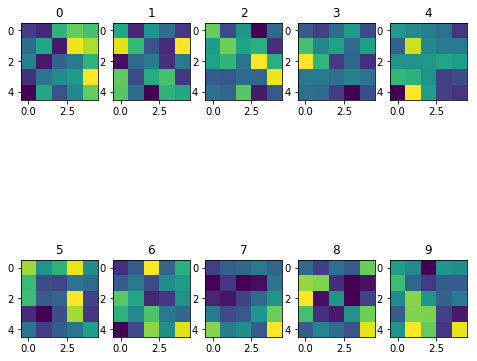

In [131]:
#print([x for x in model.layers])
plot_conv_weights(model,index=0)
w = model.get_layer(index=0).get_weights()[0]
w = np.squeeze(w)
w = w.reshape((25,10))
print(len(w.shape))

In [157]:
print(y_test[:9])

[0 0 1 1 1 0 1 1 1]


In [184]:
_ = plot_all_weights(model, n=256)

<Figure size 1080x1080 with 0 Axes>

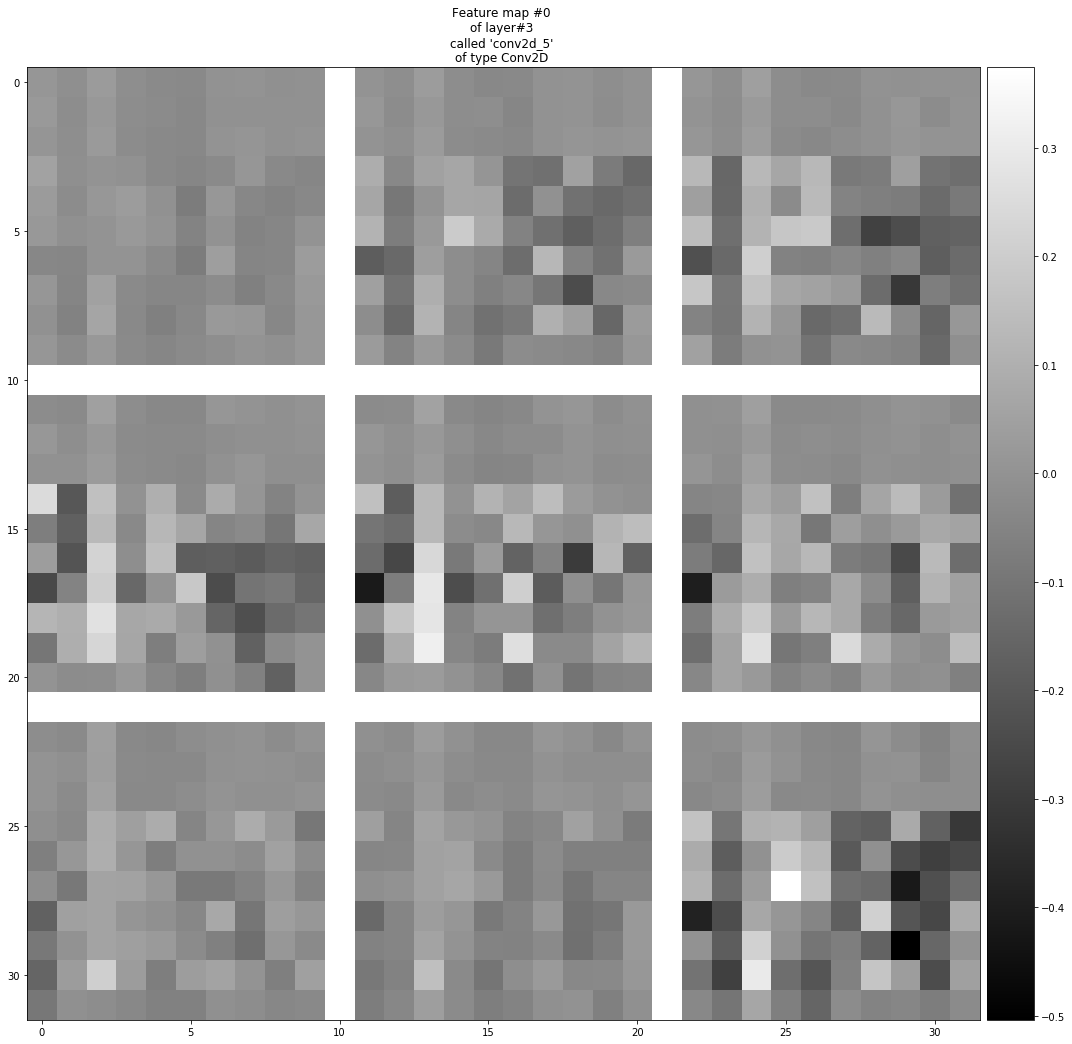

In [183]:
_ = plot_feature_map(model, 3,x_test[:1], n=9)


In [132]:
# Plotting functions

## make_mosaic(im, nrows, ncols, border=1)
## Create a numpy mosaic from a list of matrix.

## get_weights_mosaic(model, layer_id, n=64)
## Get the weights of the layer of a model as a numpy mosaic.

## plot_weights(model, layer_id, n=64, ax=None, **kwargs)
## Plot the weights of a specific layer with matplotlib

## plot_all_weights(model, n=64, **kwargs)
## Plot all the possible 2D weights in the model

## plot_feature_map(model, layer_id, X, n=256, ax=None, **kwargs)
## Plot the feature maps of the layer of a model

## plot_all_feature_maps(model, X, n=256, ax=None, **kwargs)
## Plot all the feature maps of every possible layers
def make_mosaic(im, nrows, ncols, border=1):
    """From http://nbviewer.jupyter.org/github/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb
    """
    import numpy.ma as ma

    nimgs = len(im)
    imshape = im[0].shape
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    im
    for i in range(nimgs):
        
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = im[i]
        
    return mosaic


def get_weights_mosaic(model, layer_id, n=64):
    """
    """
    
    # Get Keras layer
    layer = model.layers[layer_id]

    # Check if this layer has weight values
    if not hasattr(layer, "W"):
        raise Exception("The layer {} of type {} does not have weights.".format(layer.name,
                                                           layer.__class__.__name__))
        
    weights = layer.W.get_value()
    
    # For now we only handle Conv layer like with 4 dimensions
    if weights.ndim != 4:
        raise Exception("The layer {} has {} dimensions which is not supported.".format(layer.name, weights.ndim))
    
    # n define the maximum number of weights to display
    if weights.shape[0] < n:
        n = weights.shape[0]
        
    # Create the mosaic of weights
    nrows = int(np.round(np.sqrt(n)))
    ncols = int(nrows)

    if nrows ** 2 < n:
        ncols +=1

    mosaic = make_mosaic(weights[:n, 0], nrows, ncols, border=1)
    
    return mosaic


def plot_weights(model, layer_id, n=64, ax=None, **kwargs):
    """Plot the weights of a specific layer. ndim must be 4.
    """
    import matplotlib.pyplot as plt
    
    # Set default matplotlib parameters
    if not 'interpolation' in kwargs.keys():
        kwargs['interpolation'] = "none"
        
    if not 'cmap' in kwargs.keys():
        kwargs['cmap'] = "gray"
    
    layer = model.layers[layer_id]
    
    mosaic = get_weights_mosaic(model, layer_id, n=64)
    
    # Plot the mosaic
    if not ax:
        fig = plt.figure()
        ax = plt.subplot()
    
    im = ax.imshow(mosaic, **kwargs)
    ax.set_title("Layer #{} called '{}' of type {}".format(layer_id, layer.name, layer.__class__.__name__))
    
    plt.colorbar(im, ax=ax)
    
    return ax


def plot_all_weights(model, n=64, **kwargs):
    """
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Set default matplotlib parameters
    if not 'interpolation' in kwargs.keys():
        kwargs['interpolation'] = "none"

    if not 'cmap' in kwargs.keys():
        kwargs['cmap'] = "gray"

    layers_to_show = []

    for i, layer in enumerate(model.layers):
        if hasattr(layer, "W"):
            weights = layer.W.get_value()
            if weights.ndim == 4:
                layers_to_show.append((i, layer))


    fig = plt.figure(figsize=(15, 15))
    
    n_mosaic = len(layers_to_show)
    nrows = int(np.round(np.sqrt(n_mosaic)))
    ncols = int(nrows)

    if nrows ** 2 < n_mosaic:
        ncols +=1

    for i, (layer_id, layer) in enumerate(layers_to_show):

        mosaic = get_weights_mosaic(model, layer_id=layer_id, n=n)

        ax = fig.add_subplot(nrows, ncols, i+1)
        
        im = ax.imshow(mosaic, **kwargs)
        ax.set_title("Layer #{} called '{}' of type {}".format(layer_id, layer.name, layer.__class__.__name__))

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
        
    fig.tight_layout()
    return fig


def plot_feature_map(model, layer_id, X, n=256, ax=None, **kwargs):
    """
    """
    import keras.backend as K
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    layer = model.layers[layer_id]
    
    try:
        get_activations = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
        activations = get_activations([X, 0])[0]
    except:
        # Ugly catch, a cleaner logic is welcome here.
        raise Exception("This layer cannot be plotted.")
        
    # For now we only handle feature map with 4 dimensions
    if activations.ndim != 4:
        raise Exception("Feature map of '{}' has {} dimensions which is not supported.".format(layer.name,
                                                                                             activations.ndim))
        
    # Set default matplotlib parameters
    if not 'interpolation' in kwargs.keys():
        kwargs['interpolation'] = "none"

    if not 'cmap' in kwargs.keys():
        kwargs['cmap'] = "gray"
        
    fig = plt.figure(figsize=(15, 15))
    
    # Compute nrows and ncols for images
    n_mosaic = len(activations)
    nrows = int(np.round(np.sqrt(n_mosaic)))
    ncols = int(nrows)
    if (nrows ** 2) < n_mosaic:
        ncols +=1
        
    # Compute nrows and ncols for mosaics
    if activations[0].shape[0] < n:
        n = activations[0].shape[0]
        
    nrows_inside_mosaic = int(np.round(np.sqrt(n)))
    ncols_inside_mosaic = int(nrows_inside_mosaic)

    if nrows_inside_mosaic ** 2 < n:
        ncols_inside_mosaic += 1

    for i, feature_map in enumerate(activations):

        mosaic = make_mosaic(feature_map[:n], nrows_inside_mosaic, ncols_inside_mosaic, border=1)

        ax = fig.add_subplot(nrows, ncols, i+1)
        
        im = ax.imshow(mosaic, **kwargs)
        ax.set_title("Feature map #{} \nof layer#{} \ncalled '{}' \nof type {} ".format(i, layer_id,
                                                                                  layer.name,
                                                                                  layer.__class__.__name__))

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
            
    fig.tight_layout()
    return fig


def plot_all_feature_maps(model, X, n=256, ax=None, **kwargs):
    """
    """
    
    figs = []
    
    for i, layer in enumerate(model.layers):
        
        try:
            fig = plot_feature_map(model, i, X, n=n, ax=ax, **kwargs)
        except:
            pass
        else:
            figs.append(fig)
            
    return figs

In [38]:
def get_model(a,b,c):


    model = Sequential()
    input_shape=(fft_size, cols, 1)

    model.add(Conv2D(a, (5, 5), strides=(1, 1), input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(b, (5, 5), padding="valid"))
    model.add(MaxPooling2D((4, 2), strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(c, (5, 5), padding="valid"))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate=0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [39]:
def plot_matrix(x_test,y_test):
    prediction = []
    prediction_label =[]
    prediction_predicted = []
    for i in range(0,len(y_test)):
        prediction.append(model.predict(x_test[i].reshape(1,96,32,1))[0][0])
        prediction_label.append(y_test[i])
        prediction_predicted.append(round(prediction[i]))


    #print(prediction,prediction_label)
    #for check_item in dataset_normalized:
    #   prediction.append(model.predict(check_item[0].reshape(1,128,128,1))[0][0])
    #   prediction_label.append(check_item[1])
    #    if(prediction[-1]>0.5):
    #       prediction_predicted.append("128_7ms/ok")
    #    else:
    #        prediction_predicted.append("128_7ms/nok")

    plt.hist([prediction[x] for x in range(len(y_test)) if(prediction_label[x]==1) ],bins=40)  # arguments are passed to np.histogram
    plt.title("Prediction 1")
    plt.show()
    plt.hist([prediction[x] for x in range(len(y_test)) if(prediction_label[x]==0) ],bins=40)  # arguments are passed to np.histogram
    plt.title("Prediction 0")
    plt.show()
    matrix = confusion_matrix(y_pred=prediction_predicted,y_true=prediction_label)
    print(matrix)
    plt.figure()
    plot_confusion_matrix(matrix, classes=["Pęknięcie",'Brak pęknięcia'],
                          title='Confusion matrix, without normalization')
    precision = (matrix[0][0])/(matrix[0][0]+matrix[1][0])
    recall = (matrix[0][0])/(matrix[0][0]+matrix[0][1])
    score = 2/((1/recall) + (1/precision))
    print("Recall/Czułość: {0:0.3f}".format(recall),"Precision/Precyzja: {0:0.3f}".format(precision),"F-Score: {0:0.3f}".format(score))

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold

def load_data_kfold(k,dataset):
    random.shuffle(dataset)
    x_train, y_train = zip(*dataset)
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(x_train, y_train))
    return folds, x_train, y_train

k = 5
folds, x_train, y_train = load_data_kfold(k,dataset)

In [40]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        plot_matrix(x,y)

NameError: name 'Callback' is not defined


Fold  0
2023 229
Train on 4046 samples, validate on 564 samples
Epoch 1/55
4046/4046 [==============================] - 12s 3ms/step - loss: 0.6922 - acc: 0.5232 - val_loss: 0.7130 - val_acc: 0.1028

Epoch 00001: acc improved from -inf to 0.52323, saving model to final_model_fold_val_acc_12_mod00.0005_weights.hdf5
Epoch 2/55
4046/4046 [==============================] - 12s 3ms/step - loss: 0.6821 - acc: 0.5751 - val_loss: 0.6698 - val_acc: 0.7713

Epoch 00002: acc improved from 0.52323 to 0.57514, saving model to final_model_fold_val_acc_12_mod00.0005_weights.hdf5
Epoch 3/55
4046/4046 [==============================] - 12s 3ms/step - loss: 0.6172 - acc: 0.7173 - val_loss: 0.5114 - val_acc: 0.9291

Epoch 00003: acc improved from 0.57514 to 0.71725, saving model to final_model_fold_val_acc_12_mod00.0005_weights.hdf5
Epoch 4/55
4046/4046 [==============================] - 12s 3ms/step - loss: 0.5059 - acc: 0.7763 - val_loss: 0.4671 - val_acc: 0.9078

Epoch 00004: acc improved from 0.7172

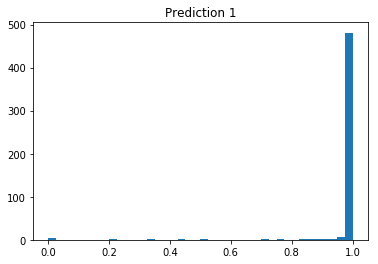

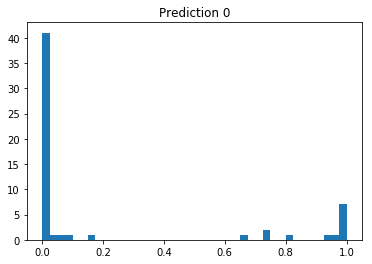

[[ 45  13]
 [  8 498]]
Confusion matrix, without normalization
Recall/Czułość: 0.776 Precision/Precyzja: 0.849 F-Score: 0.811

Fold  1
2023 229
Train on 4046 samples, validate on 564 samples
Epoch 1/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.6930 - acc: 0.5161 - val_loss: 0.6922 - val_acc: 0.7305

Epoch 00001: acc improved from -inf to 0.51607, saving model to final_model_fold_val_acc_12_mod10.0005_weights.hdf5
Epoch 2/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.6873 - acc: 0.5522 - val_loss: 0.7267 - val_acc: 0.1188

Epoch 00002: acc improved from 0.51607 to 0.55215, saving model to final_model_fold_val_acc_12_mod10.0005_weights.hdf5
Epoch 3/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.6537 - acc: 0.6572 - val_loss: 0.6813 - val_acc: 0.7145

Epoch 00003: acc improved from 0.55215 to 0.65719, saving model to final_model_fold_val_acc_12_mod10.0005_weights.hdf5
Epoch 4/55
4046/4046 [=========================

4046/4046 [==============================] - 15s 4ms/step - loss: 0.0120 - acc: 0.9973 - val_loss: 0.0903 - val_acc: 0.9752

Epoch 00034: acc did not improve from 0.99728
Epoch 35/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.0122 - acc: 0.9978 - val_loss: 0.0967 - val_acc: 0.9752

Epoch 00035: acc improved from 0.99728 to 0.99778, saving model to final_model_fold_val_acc_12_mod10.0005_weights.hdf5
Epoch 36/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.0101 - acc: 0.9980 - val_loss: 0.0962 - val_acc: 0.9787

Epoch 00036: acc improved from 0.99778 to 0.99802, saving model to final_model_fold_val_acc_12_mod10.0005_weights.hdf5
Epoch 37/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.0105 - acc: 0.9970 - val_loss: 0.0958 - val_acc: 0.9770

Epoch 00037: acc did not improve from 0.99802
Epoch 38/55
4046/4046 [==============================] - 14s 4ms/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.0891 - val_acc: 0.980

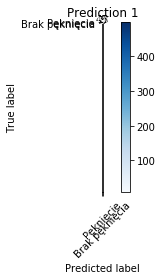

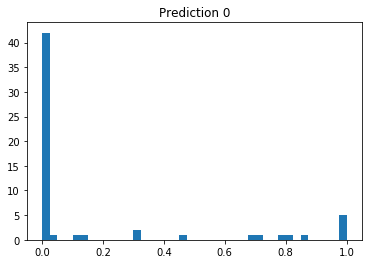

[[ 48  10]
 [  4 502]]
Confusion matrix, without normalization
Recall/Czułość: 0.828 Precision/Precyzja: 0.923 F-Score: 0.873

Fold  2
2023 230
Train on 4046 samples, validate on 563 samples
Epoch 1/55
4046/4046 [==============================] - 14s 4ms/step - loss: 0.6925 - acc: 0.4998 - val_loss: 0.6927 - val_acc: 0.7318

Epoch 00001: acc improved from -inf to 0.49975, saving model to final_model_fold_val_acc_12_mod20.0005_weights.hdf5
Epoch 2/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.6691 - acc: 0.6458 - val_loss: 0.7074 - val_acc: 0.7442

Epoch 00002: acc improved from 0.49975 to 0.64582, saving model to final_model_fold_val_acc_12_mod20.0005_weights.hdf5
Epoch 3/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.5730 - acc: 0.7706 - val_loss: 0.6156 - val_acc: 0.8277

Epoch 00003: acc improved from 0.64582 to 0.77064, saving model to final_model_fold_val_acc_12_mod20.0005_weights.hdf5
Epoch 4/55
4046/4046 [=========================

4046/4046 [==============================] - 14s 4ms/step - loss: 0.0177 - acc: 0.9973 - val_loss: 0.1091 - val_acc: 0.9787

Epoch 00033: acc did not improve from 0.99827
Epoch 34/55
4046/4046 [==============================] - 16s 4ms/step - loss: 0.0135 - acc: 0.9983 - val_loss: 0.1097 - val_acc: 0.9787

Epoch 00034: acc did not improve from 0.99827
Epoch 35/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.0116 - acc: 0.9988 - val_loss: 0.1066 - val_acc: 0.9787

Epoch 00035: acc improved from 0.99827 to 0.99876, saving model to final_model_fold_val_acc_12_mod20.0005_weights.hdf5
Epoch 36/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.0111 - acc: 0.9993 - val_loss: 0.1124 - val_acc: 0.9787

Epoch 00036: acc improved from 0.99876 to 0.99926, saving model to final_model_fold_val_acc_12_mod20.0005_weights.hdf5
Epoch 37/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.0104 - acc: 0.9988 - val_loss: 0.1050 - val_acc: 0.980

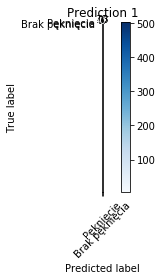

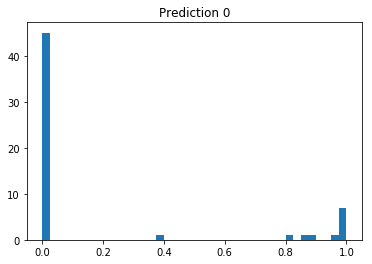

[[ 46  11]
 [  1 505]]
Confusion matrix, without normalization
Recall/Czułość: 0.807 Precision/Precyzja: 0.979 F-Score: 0.885

Fold  3
2023 230
Train on 4046 samples, validate on 563 samples
Epoch 1/55
4046/4046 [==============================] - 16s 4ms/step - loss: 0.6924 - acc: 0.5198 - val_loss: 0.7018 - val_acc: 0.1012

Epoch 00001: acc improved from -inf to 0.51977, saving model to final_model_fold_val_acc_12_mod30.0005_weights.hdf5
Epoch 2/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.6845 - acc: 0.5709 - val_loss: 0.6932 - val_acc: 0.6803

Epoch 00002: acc improved from 0.51977 to 0.57093, saving model to final_model_fold_val_acc_12_mod30.0005_weights.hdf5
Epoch 3/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.6350 - acc: 0.6824 - val_loss: 0.5852 - val_acc: 0.8384

Epoch 00003: acc improved from 0.57093 to 0.68240, saving model to final_model_fold_val_acc_12_mod30.0005_weights.hdf5
Epoch 4/55
4046/4046 [=========================

4046/4046 [==============================] - 15s 4ms/step - loss: 0.0162 - acc: 0.9960 - val_loss: 0.2034 - val_acc: 0.9663

Epoch 00035: acc did not improve from 0.99679
Epoch 36/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.0112 - acc: 0.9973 - val_loss: 0.2153 - val_acc: 0.9645

Epoch 00036: acc improved from 0.99679 to 0.99728, saving model to final_model_fold_val_acc_12_mod30.0005_weights.hdf5
Epoch 37/55
4046/4046 [==============================] - 14s 3ms/step - loss: 0.0120 - acc: 0.9956 - val_loss: 0.2088 - val_acc: 0.9680

Epoch 00037: acc did not improve from 0.99728
Epoch 38/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.0106 - acc: 0.9980 - val_loss: 0.2135 - val_acc: 0.9680

Epoch 00038: acc improved from 0.99728 to 0.99802, saving model to final_model_fold_val_acc_12_mod30.0005_weights.hdf5
Epoch 39/55
4046/4046 [==============================] - 15s 4ms/step - loss: 0.0093 - acc: 0.9975 - val_loss: 0.2203 - val_acc: 0.968

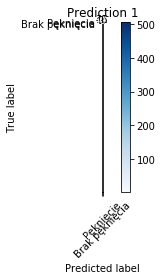

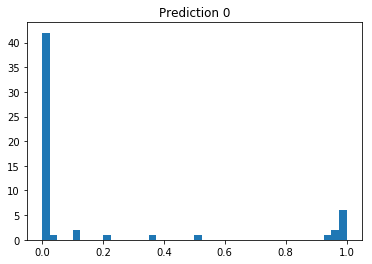

[[ 47  10]
 [ 11 495]]
Confusion matrix, without normalization
Recall/Czułość: 0.825 Precision/Precyzja: 0.810 F-Score: 0.817

Fold  4
2024 230
Train on 4048 samples, validate on 562 samples
Epoch 1/55
4048/4048 [==============================] - 15s 4ms/step - loss: 0.6916 - acc: 0.5324 - val_loss: 0.7365 - val_acc: 0.1014

Epoch 00001: acc improved from -inf to 0.53236, saving model to final_model_fold_val_acc_12_mod40.0005_weights.hdf5
Epoch 2/55
4048/4048 [==============================] - 15s 4ms/step - loss: 0.6865 - acc: 0.5531 - val_loss: 0.6792 - val_acc: 0.8060

Epoch 00002: acc improved from 0.53236 to 0.55311, saving model to final_model_fold_val_acc_12_mod40.0005_weights.hdf5
Epoch 3/55
4048/4048 [==============================] - 14s 3ms/step - loss: 0.6503 - acc: 0.6747 - val_loss: 0.7006 - val_acc: 0.7224

Epoch 00003: acc improved from 0.55311 to 0.67465, saving model to final_model_fold_val_acc_12_mod40.0005_weights.hdf5
Epoch 4/55
4048/4048 [=========================

4048/4048 [==============================] - 14s 4ms/step - loss: 0.0205 - acc: 0.9973 - val_loss: 0.0816 - val_acc: 0.9822

Epoch 00035: acc improved from 0.99580 to 0.99728, saving model to final_model_fold_val_acc_12_mod40.0005_weights.hdf5
Epoch 36/55
4048/4048 [==============================] - 15s 4ms/step - loss: 0.0191 - acc: 0.9958 - val_loss: 0.0812 - val_acc: 0.9804

Epoch 00036: acc did not improve from 0.99728
Epoch 37/55
4048/4048 [==============================] - 15s 4ms/step - loss: 0.0164 - acc: 0.9973 - val_loss: 0.0836 - val_acc: 0.9804

Epoch 00037: acc did not improve from 0.99728
Epoch 38/55
4048/4048 [==============================] - 15s 4ms/step - loss: 0.0151 - acc: 0.9973 - val_loss: 0.0863 - val_acc: 0.9786

Epoch 00038: acc did not improve from 0.99728
Epoch 39/55
4048/4048 [==============================] - 15s 4ms/step - loss: 0.0136 - acc: 0.9973 - val_loss: 0.1048 - val_acc: 0.9698

Epoch 00039: acc did not improve from 0.99728
Epoch 40/55
4048/4048 [=

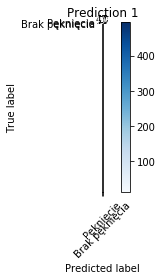

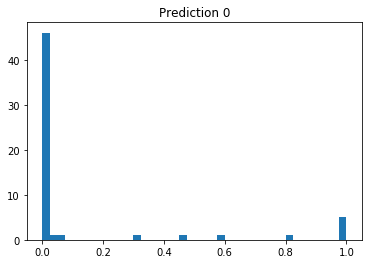

[[ 50   7]
 [  4 501]]
Confusion matrix, without normalization
Recall/Czułość: 0.877 Precision/Precyzja: 0.926 F-Score: 0.901


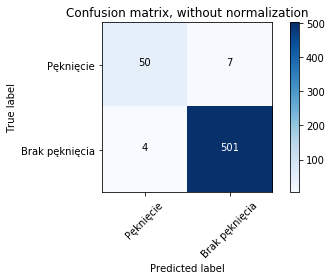

In [13]:
#cross validation
for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j)
    X_train_cv = [x_train[x] for x in train_idx]
    y_train_cv = [y_train[x] for x in train_idx]
    data_fold = list(zip(X_train_cv,y_train_cv))
    data_fold = Oversampling(data_fold)
    X_train_cv,y_train_cv=zip(*data_fold)
    X_valid_cv = [x_train[x] for x in val_idx]
    y_valid_cv = [y_train[x] for x in val_idx]
    fft_size=96
    cols = 32
    X_train_cv = np.array([x.reshape( (fft_size, cols, 1) ) for x in X_train_cv])
    X_valid_cv = np.array([x.reshape( (fft_size, cols, 1) ) for x in X_valid_cv])
    
    encoder = LabelEncoder()
    encoder.fit(y_train_cv)
    y_train_cv = encoder.transform(y_train_cv)
    y_valid_cv = encoder.transform(y_valid_cv)
    #print(X_train_cv)
   

    
    model = get_model(12,12,12)
    lr = 0.0005
    optimazerAdam = keras.optimizers.Adam(lr=lr, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss='binary_crossentropy',
                  optimizer="Adam",
                  metrics=['acc'])#accuracy
    
    name_weights = "final_model_fold_val_acc_12_mod" + str(j) + str(lr) + "_weights"
    Tensor_board = keras.callbacks.TensorBoard(log_dir=name_weights, write_images=True)
    checkpoint = keras.callbacks.ModelCheckpoint(name_weights+".hdf5",monitor="acc", verbose=1, save_best_only=True)
    callbacks_list = [checkpoint,Tensor_board,TestCallback((X_valid_cv, y_valid_cv))]
    
    model.fit(X_train_cv,
            y_train_cv,
            epochs=55,
            batch_size=128,
            validation_data =(X_valid_cv, y_valid_cv),
            callbacks = callbacks_list)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
    plot_matrix(X_valid_cv,y_valid_cv)


Fold  0
2023 229
564/564 [==============================] - 1s 2ms/step
[0.16564825402757694, 0.9680851063829787]


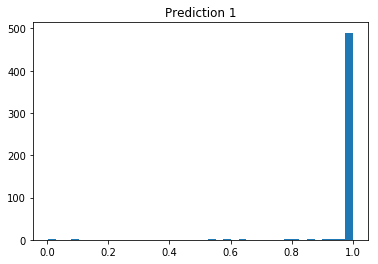

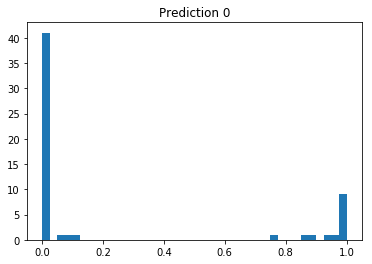

[[ 44  14]
 [  4 502]]
Confusion matrix, without normalization
Recall/Czułość: 0.759 Precision/Precyzja: 0.917 F-Score: 0.830

Fold  1
2023 229
564/564 [==============================] - 1s 2ms/step
[0.1197120435684523, 0.9716312056737588]


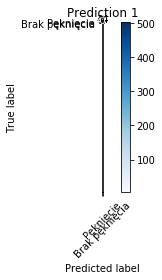

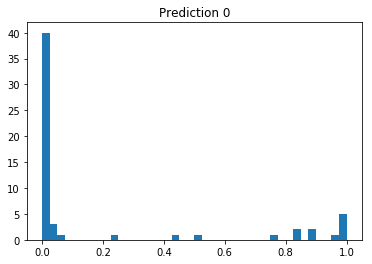

[[ 46  12]
 [  4 502]]
Confusion matrix, without normalization
Recall/Czułość: 0.793 Precision/Precyzja: 0.920 F-Score: 0.852

Fold  2
2023 230
563/563 [==============================] - 1s 2ms/step
[0.12253008687746303, 0.9804618111935645]


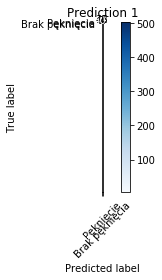

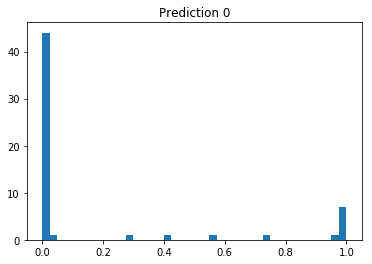

[[ 47  10]
 [  1 505]]
Confusion matrix, without normalization
Recall/Czułość: 0.825 Precision/Precyzja: 0.979 F-Score: 0.895

Fold  3
2023 230
563/563 [==============================] - 1s 2ms/step
[0.2530371066911533, 0.9644760213143873]


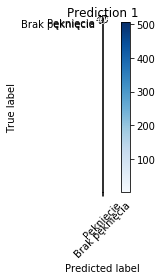

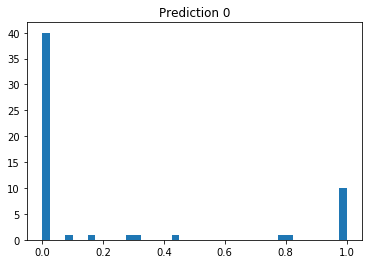

[[ 45  12]
 [  8 498]]
Confusion matrix, without normalization
Recall/Czułość: 0.789 Precision/Precyzja: 0.849 F-Score: 0.818

Fold  4
2024 230
562/562 [==============================] - 1s 2ms/step
[0.09264460499907987, 0.9839857651245552]


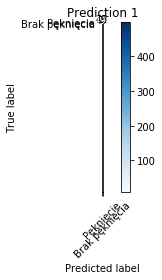

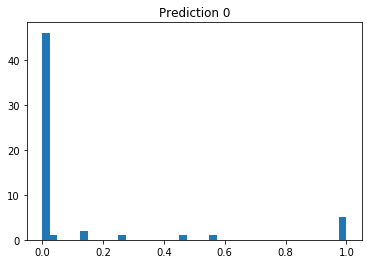

[[ 51   6]
 [  3 502]]
Confusion matrix, without normalization
Recall/Czułość: 0.895 Precision/Precyzja: 0.944 F-Score: 0.919


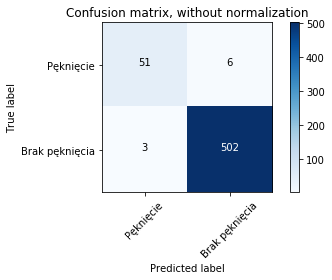

In [25]:
for j, (train_idx, val_idx) in enumerate(folds):
    K = [48,24,12,10,5]
    print('\nFold ',j)
    X_train_cv = [x_train[x] for x in train_idx]
    y_train_cv = [y_train[x] for x in train_idx]
    data_fold = list(zip(X_train_cv,y_train_cv))
    data_fold = Oversampling(data_fold)
    X_train_cv,y_train_cv=zip(*data_fold)
    X_valid_cv = [x_train[x] for x in val_idx]
    y_valid_cv = [y_train[x] for x in val_idx]
    fft_size=96
    cols = 32
    X_train_cv = np.array([x.reshape( (fft_size, cols, 1) ) for x in X_train_cv])
    X_valid_cv = np.array([x.reshape( (fft_size, cols, 1) ) for x in X_valid_cv])
    model = get_model(12,12,12)
    model.compile(loss='binary_crossentropy',
                  optimizer="Adam",
                  metrics=['acc'])#accuracy
    encoder = LabelEncoder()
    encoder.fit(y_train_cv)
    y_train_cv = encoder.transform(y_train_cv)
    y_valid_cv = encoder.transform(y_valid_cv)
    #print(X_train_cv)
    name_weights = "final_model_fold_val_acc_12_mod" + str(j) + "0.0005_weights.hdf5"
    model.load_weights(name_weights)#dodaj d
    print(model.evaluate(X_valid_cv, y_valid_cv))
    plot_matrix(X_valid_cv,y_valid_cv)